#**Simple Way to Detect Noisy Labels**

By : [Leo C. D.](https://www.aicrowd.com/participants/leocd)

As we know, the main challenge of the round 2 is noisy and imbalanced label.

So here's my simple way to eliminate noisy label, especially the scratch mark, by using **cv2**

First, Let's Load Data from Round 1 first, as we know, the label is quite clean and balance

##Setting up

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm

In [2]:
#@title Login to AIcrowd
!pip install -U aicrowd-cli > /dev/null
!aicrowd login 2> /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Please login here: https://api.aicrowd.com/auth/aMhj3AgWQkn8VQ6lZH5FXWRkhw6C5UCRY_rPZM-ATyI
API Key valid
Gitlab access token valid
Saved details successfully!


In [3]:
#@title Magic Box ⬛ { vertical-output: true, display-mode: "form" }
try:
  import os
  if first_run and os.path.exists("/content/data-purchasing-challenge-2022-starter-kit/data/unlabelled"):
    first_run = False
except:
  first_run = True

if first_run:
  %cd /content/
  !git clone http://gitlab.aicrowd.com/zew/data-purchasing-challenge-2022-starter-kit.git > /dev/null
  %cd data-purchasing-challenge-2022-starter-kit
  !aicrowd dataset list -c data-purchasing-challenge-2022
  !aicrowd dataset download -c data-purchasing-challenge-2022
  !mkdir -p data/
  !mv *.tar.gz data/ && cd data && echo "Extracting dataset" && ls *.tar.gz | xargs -n1 -I{} bash -c "tar -xvf {} > /dev/null"


def run_pre_training_phase():
  from run import ZEWDPCBaseRun
  run = ZEWDPCBaseRun()
  run.pre_training_phase = pre_training_phase
  run.pre_training_phase(self=run, training_dataset=training_dataset)
  # NOTE:It is critical that the checkpointing works in a self-contained way
  #      As, the evaluators might choose to run the different phases separately.
  run.save_checkpoint("/tmp/pretrainig_phase_checkpoint.pickle")

def run_purchase_phase():
  from run import ZEWDPCBaseRun
  run = ZEWDPCBaseRun()
  run.pre_training_phase = pre_training_phase
  run.purchase_phase = purchase_phase
  run.load_checkpoint("/tmp/pretrainig_phase_checkpoint.pickle")
  # Hacky way to make it work in notebook
  unlabelled_dataset.purchases = set()
  run.purchase_phase(self=run, unlabelled_dataset=unlabelled_dataset, training_dataset=training_dataset, budget=3000)
  run.save_checkpoint("/tmp/purchase_phase_checkpoint.pickle")
  del run

def run_prediction_phase():
  from run import ZEWDPCBaseRun
  run = ZEWDPCBaseRun()
  run.pre_training_phase = pre_training_phase
  run.purchase_phase = purchase_phase
  run.prediction_phase = prediction_phase
  run.load_checkpoint("/tmp/purchase_phase_checkpoint.pickle")
  run.prediction_phase(self=run, test_dataset=val_dataset)
  del run

/content
Cloning into 'data-purchasing-challenge-2022-starter-kit'...
remote: Enumerating objects: 405, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 405 (delta 191), reused 280 (delta 171), pack-reused 99
Receiving objects: 100% (405/405), 104.79 KiB | 599.00 KiB/s, done.
Resolving deltas: 100% (245/245), done.
/content/data-purchasing-challenge-2022-starter-kit
                          Datasets for challenge #1024                          
┌───┬─────────────────────────┬──────────────────────────────────────┬─────────┐
│ # │ Title                   │ Description                          │    Size │
├───┼─────────────────────────┼──────────────────────────────────────┼─────────┤
│ 0 │ debug-v0.1.tar.gz       │ Debug dataset                        │ 6.1 MiB │
│ 1 │ debug-v0.2-rc4.zip      │ Debug data for round 2               │   6 MiB │
│ 2 │ training-v0.1.tar.gz    │ Training data                        │ 304 

In [5]:
!rm -r data/unlabelled

In [ ]:
!tar -xzvf "/content/data-purchasing-challenge-2022-starter-kit/data/unlabelled.tar.gz" -C "./data/"
!mkdir data_round2
!unzip "./unlabelled-v0.2-rc4.zip" -d "./data_round2"

---

##Getting Clean Label Info from Round 1 Data

In [ ]:
labelu_r1 = pd.read_csv(r'.\data\unlabelled\labels.csv')
labelu_r1

filename  scratch_small  scratch_large  dent_small  dent_large
0     00O1rwvydO.png              0              0           0           0
1     01bB3DVokm.png              1              0           0           0
2     01sAbrP4Gm.png              0              0           0           0
3     02XiKLPuxY.png              0              0           0           0
4     02bVIX0aMT.png              0              1           0           0
...              ...            ...            ...         ...         ...
9995  zwjPUVHAQy.png              0              0           1           0
9996  zwtEorOjmX.png              1              0           0           1
9997  zxZKEA9OMI.png              0              0           0           0
9998  zxmnO7Zt5o.png              1              0           0           0
9999  zxxRwwUeEv.png              1              0           1           0

[10000 rows x 5 columns]

let's get the heavily damaged data which got all the label

In [ ]:
labelscr = labelu_r1[(labelu_r1['scratch_small']==1) & (labelu_r1['scratch_large']==1) & (labelu_r1['dent_small']==1)& (labelu_r1['dent_large']==1)]

In [ ]:
labelscr

filename  scratch_small  scratch_large  dent_small  dent_large
238   1SuRMIiysb.png              1              1           1           1
261   1bNY8WF9ag.png              1              1           1           1
408   2PFdmVacOS.png              1              1           1           1
556   3HpqF4Fo1v.png              1              1           1           1
580   3QKS6GihCc.png              1              1           1           1
...              ...            ...            ...         ...         ...
9684  y8ZtCnvaiC.png              1              1           1           1
9710  yJa3RY4zXM.png              1              1           1           1
9721  yOv11ZZMtg.png              1              1           1           1
9796  yldO6V9DC9.png              1              1           1           1
9805  ypGhx8EWhk.png              1              1           1           1

[108 rows x 5 columns]

let's check the image

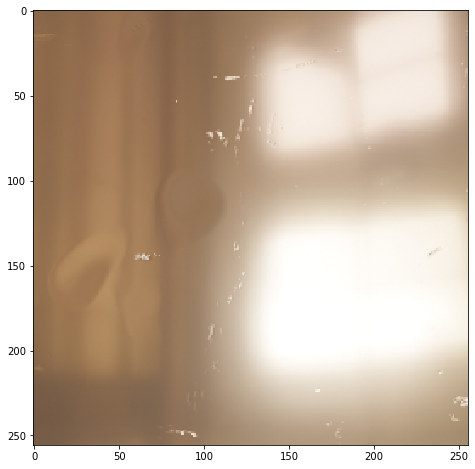

In [ ]:
i = 3
fname = r'./data/unlabelled/images/' + labelscr.iloc[i,0]
im = Image.open(fname)
cv_image = np.array(im)
plt.figure(figsize=(8,8))
plt.imshow(cv_image, interpolation='none')
plt.show()

using method from my [first notebook here](https://www.aicrowd.com/showcase/exploration-body-paint-color-dominance-image-transforms)   (pls leave some likes   ❤️  !)

Let's apply it to the images!

In [ ]:
kernel = np.array([[0, -1, 0],
                   [-1, 4, -1],
                   [0, -1, 0]])

In [ ]:
sharp_img = cv2.filter2D(src=cv_image, ddepth=-1, kernel=kernel)
sharp_img = cv2.cvtColor(sharp_img, cv2.COLOR_BGR2GRAY)

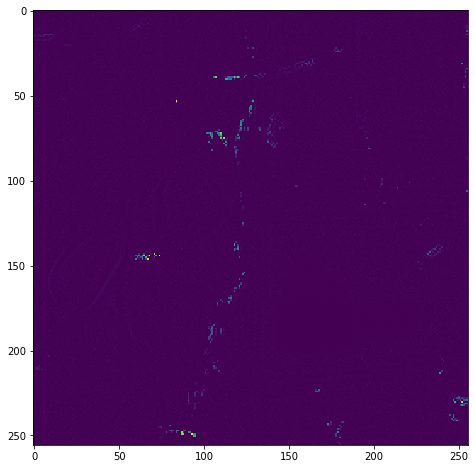

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(sharp_img, interpolation='none')
plt.show()

now you can see the filter can separate the scratch defect from the background. Also, the maximum value can be extracted as a feature where I explain later why this is important.

In [ ]:
sharp_img.max()

254

now let's enhance the intensity of the defects and find the countours!

In [ ]:
ret,sharp_img1 = cv2.threshold(sharp_img,30,255,cv2.THRESH_BINARY)
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
dilation = cv2.dilate(sharp_img1,kernel2,iterations = 1)
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE )    

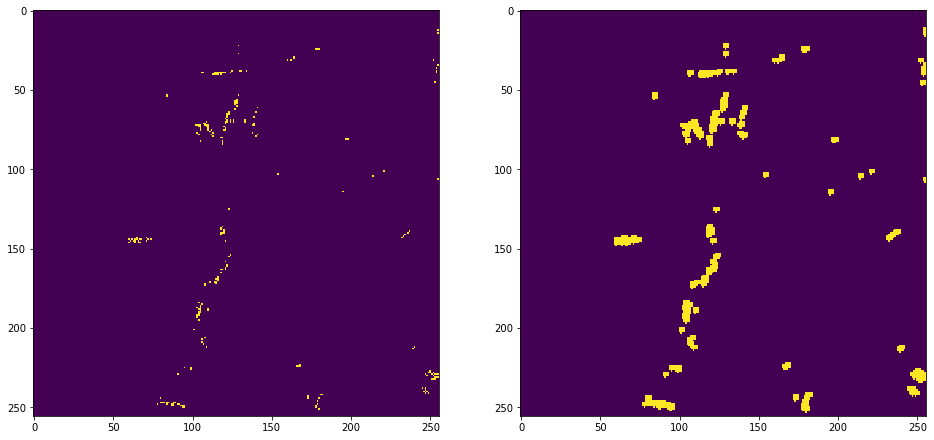

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))
ax1.imshow(sharp_img1, interpolation='none')
ax2.imshow(dilation, interpolation='none')
plt.show()

for visualization, here's the defect contour that we got! 

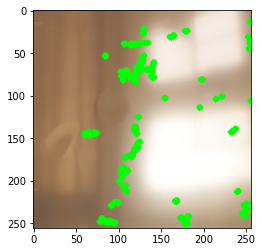

In [ ]:
contour = sorted(contours, key=cv2.contourArea)
contourImg = cv2.drawContours(cv_image.copy(), contour, -1, (0,255,0), 3)
plt.figure(figsize=(8,8))
plt.imshow(contourImg)
plt.show()

now, with the sharp sharp_img.max(), let's save another feature like : 

the smallest defect area, the largest defect area, and etc.

In [ ]:
sharpval = []
for i in tqdm(range(0,len(labelu_r1))):

    fname = r'./data/unlabelled/images/' + labelu_r1.iloc[i,0]
    im = Image.open(fname)
    cv_image = np.array(im)

    kernel = np.array([[0, -1, 0],
                       [-1, 4, -1],
                       [0, -1, 0]])

    sharp_img = cv2.filter2D(src=cv_image, ddepth=-1, kernel=kernel)
    sharp_img = cv2.cvtColor(sharp_img, cv2.COLOR_BGR2GRAY)
    ret,sharp_img1 = cv2.threshold(sharp_img,30,255,cv2.THRESH_BINARY)
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
    dilation = cv2.dilate(sharp_img1,kernel2,iterations = 1)
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE )    
    
    # getting area
    c5 = 0
    c10 = 0
    c15 = 0
    c20 = 0
    c30 = 0
    c40 = 0
    c50 = 0
    c80 = 0
    c100 = 0
    c150 = 0
    c200 = 0
    c300 = 0
    c400 = 0
    c500 = 0
    
    areas = []
    for j in contours:
        area = cv2.contourArea(j)
        if area<10000 and area>5: #this to limit incase the cv returning a contour somewhat larger than the image itself
            areas.append(area)
            if 5 <= area < 10:
                c5 = c5 + 1
            if 10 <= area < 15:
                c10 = c10 + 1
            if 15 <= area < 20:
                c15 = c15 + 1
            if 20 <= area < 30:
                c20 = c20 + 1
            if 30 <= area < 40:
                c30 = c30 + 1
            if 40 <= area < 50:
                c40 = c40 + 1
            if 50 <= area < 80:
                c50 = c50 + 1
            if 80 <= area < 100:
                c80 = c80 + 1
            if 100 <= area < 150:
                c100 = c100 + 1   
            if 150 <= area < 200:
                c150 = c150 + 1
            if 200 <= area < 300:
                c200 = c200 + 1
            if 300 <= area < 400:
                c300 = c300 + 1
            if 400 <= area < 500:
                c400 = c400 + 1
            if area > 500:
                c500 = c500 + 1  
    if areas:
        cnt = [min(areas), max(areas), len(areas)]
    else:
        cnt = [0,0,0]    
    
    sharpval.append([sharp_img.max(), cnt[0], cnt[1], cnt[2], c5, c10, c15, c20, c30, c40, c50, c80, c100, c150, c200, c300, c400, c500])
scratch_res = pd.DataFrame(np.array(sharpval),columns=['sharp','min_size','max_size', 'n_con', 'c5', 'c10', 'c15', 'c20', 'c30', 'c40', 'c50', 'c80', 'c100', 'c150', 'c200', 'c300', 'c400', 'c500'])


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 287.16it/s]


In [ ]:
scratch_res

sharp  min_size  max_size  n_con    c5   c10  c15  c20  c30  c40  c50  \
0       7.0       0.0       0.0    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   
1     168.0       7.0      92.0   22.0   9.0  10.0  0.0  1.0  0.0  0.0  1.0   
2       8.0       0.0       0.0    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   
3      16.0       0.0       0.0    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   
4     254.0       7.0     246.0   17.0   5.0   2.0  2.0  2.0  1.0  0.0  2.0   
...     ...       ...       ...    ...   ...   ...  ...  ...  ...  ...  ...   
9995   18.0       0.0       0.0    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   
9996  107.0       7.0      35.0    7.0   3.0   1.0  2.0  0.0  1.0  0.0  0.0   
9997   16.0       0.0       0.0    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   
9998  154.0       7.0      15.0   15.0   8.0   6.0  1.0  0.0  0.0  0.0  0.0   
9999  131.0       7.0      64.0   20.0  11.0   3.0  4.0  0.0  0.0  1.0  1.0   

      c80  c100  c150  c200  c300  c400  c500  
0     0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1     1.0   0.0   0.0   0.0   0.0   0.0   0.0  
2     0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3     0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4     1.0   1.0   0.0   1.0   0.0   0.0   0.0  
...   ...   ...   ...   ...   ...   ...   ...  
9995  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9996  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9997  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9998  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9999  0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[10000 rows x 18 columns]

In [ ]:
labelu_r1['scratch_flag'] = 0
labelu_r1['scratch_flag'][(labelu_r1['scratch_small'] == 1 ) | (labelu_r1['scratch_large'] == 1 )] = 1

C:\Users\leo.dinendra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
labelu_r1

filename  scratch_small  scratch_large  dent_small  dent_large  \
0     00O1rwvydO.png              0              0           0           0   
1     01bB3DVokm.png              1              0           0           0   
2     01sAbrP4Gm.png              0              0           0           0   
3     02XiKLPuxY.png              0              0           0           0   
4     02bVIX0aMT.png              0              1           0           0   
...              ...            ...            ...         ...         ...   
9995  zwjPUVHAQy.png              0              0           1           0   
9996  zwtEorOjmX.png              1              0           0           1   
9997  zxZKEA9OMI.png              0              0           0           0   
9998  zxmnO7Zt5o.png              1              0           0           0   
9999  zxxRwwUeEv.png              1              0           1           0   

      scratch_flag  
0                0  
1                1  
2                0  
3                0  
4                1  
...            ...  
9995             0  
9996             1  
9997             0  
9998             1  
9999             1  

[10000 rows x 6 columns]

In [ ]:
recap_res = pd.concat([labelu_r1, scratch_res],axis=1)
recap_res

filename  scratch_small  scratch_large  dent_small  dent_large  \
0     00O1rwvydO.png              0              0           0           0   
1     01bB3DVokm.png              1              0           0           0   
2     01sAbrP4Gm.png              0              0           0           0   
3     02XiKLPuxY.png              0              0           0           0   
4     02bVIX0aMT.png              0              1           0           0   
...              ...            ...            ...         ...         ...   
9995  zwjPUVHAQy.png              0              0           1           0   
9996  zwtEorOjmX.png              1              0           0           1   
9997  zxZKEA9OMI.png              0              0           0           0   
9998  zxmnO7Zt5o.png              1              0           0           0   
9999  zxxRwwUeEv.png              1              0           1           0   

      scratch_flag  sharp  min_size  max_size  n_con  ...  c30  c40  c50  c80  \
0                0    7.0       0.0       0.0    0.0  ...  0.0  0.0  0.0  0.0   
1                1  168.0       7.0      92.0   22.0  ...  0.0  0.0  1.0  1.0   
2                0    8.0       0.0       0.0    0.0  ...  0.0  0.0  0.0  0.0   
3                0   16.0       0.0       0.0    0.0  ...  0.0  0.0  0.0  0.0   
4                1  254.0       7.0     246.0   17.0  ...  1.0  0.0  2.0  1.0   
...            ...    ...       ...       ...    ...  ...  ...  ...  ...  ...   
9995             0   18.0       0.0       0.0    0.0  ...  0.0  0.0  0.0  0.0   
9996             1  107.0       7.0      35.0    7.0  ...  1.0  0.0  0.0  0.0   
9997             0   16.0       0.0       0.0    0.0  ...  0.0  0.0  0.0  0.0   
9998             1  154.0       7.0      15.0   15.0  ...  0.0  0.0  0.0  0.0   
9999             1  131.0       7.0      64.0   20.0  ...  0.0  1.0  1.0  0.0   

      c100  c150  c200  c300  c400  c500  
0      0.0   0.0   0.0   0.0   0.0   0.0  
1      0.0   0.0   0.0   0.0   0.0   0.0  
2      0.0   0.0   0.0   0.0   0.0   0.0  
3      0.0   0.0   0.0   0.0   0.0   0.0  
4      1.0   0.0   1.0   0.0   0.0   0.0  
...    ...   ...   ...   ...   ...   ...  
9995   0.0   0.0   0.0   0.0   0.0   0.0  
9996   0.0   0.0   0.0   0.0   0.0   0.0  
9997   0.0   0.0   0.0   0.0   0.0   0.0  
9998   0.0   0.0   0.0   0.0   0.0   0.0  
9999   0.0   0.0   0.0   0.0   0.0   0.0  

[10000 rows x 24 columns]

let's see the distribution from one of the feature we just extracted which is maximum 'sharp' values.

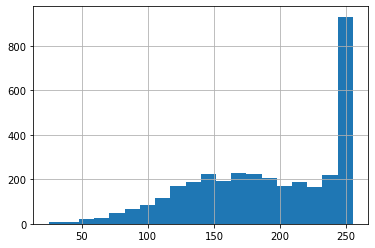

In [ ]:
recap_res['sharp'][recap_res['scratch_flag'] == 1].hist(bins=20)

In [ ]:
recap_res['sharp'][recap_res['scratch_flag'] == 1].describe()

count    3486.000000
mean      189.485657
std        55.329572
min        25.000000
25%       146.000000
50%       193.000000
75%       247.000000
max       255.000000
Name: sharp, dtype: float64

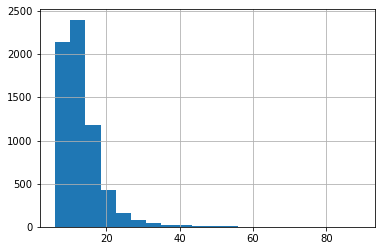

In [ ]:
recap_res['sharp'][recap_res['scratch_flag'] == 0].hist(bins=20)

In [ ]:
recap_res['sharp'][recap_res['scratch_flag'] == 0].describe()

count    6514.000000
mean       13.389776
std         6.000708
min         6.000000
25%        10.000000
50%        12.000000
75%        15.000000
max        89.000000
Name: sharp, dtype: float64

Well look at that, by just using one of the features, you can pretty much divide which image got scratch defect or not.

you can play around with the size contour and every contour length counted available to try find another kind of defect.

now, let's try to apply it on our second dataset!

---

##Apply it to Round 2 Data

In [ ]:
labelu_r2 = pd.read_csv(r'.\data_round2\unlabelled\labels.csv')
labelu_r2

filename  scratch_small  scratch_large  dent_small  dent_large  \
0     mxQiOKkCi7.png              0              0           0           0   
1     F8E3dsmnSP.png              0              0           0           0   
2     obeLGzdD8T.png              1              0           0           0   
3     vbyjMQ90i6.png              0              0           1           0   
4     RdzUUAkSVC.png              0              0           0           0   
...              ...            ...            ...         ...         ...   
9995  FWmzmcWsvK.png              0              0           0           0   
9996  McdXs4y8d7.png              0              0           0           0   
9997  jFNmZC4LF4.png              0              0           0           0   
9998  OiPXgurZKH.png              0              0           0           0   
9999  lr41fb2k0u.png              0              0           0           0   

      stray_particle  discoloration  
0                  0              0  
1                  0              0  
2                  0              0  
3                  0              0  
4                  0              0  
...              ...            ...  
9995               1              0  
9996               1              0  
9997               1              0  
9998               1              0  
9999               0              0  

[10000 rows x 7 columns]

In [ ]:
sharpval = []
for i in tqdm(range(0,len(labelu_r2))):

    fname = r'./data_round2/unlabelled/images/' + labelu_r2.iloc[i,0]
    im = Image.open(fname)
    cv_image = np.array(im)

    kernel = np.array([[0, -1, 0],
                       [-1, 4, -1],
                       [0, -1, 0]])

    sharp_img = cv2.filter2D(src=cv_image, ddepth=-1, kernel=kernel)
    sharp_img = cv2.cvtColor(sharp_img, cv2.COLOR_BGR2GRAY)
    ret,sharp_img1 = cv2.threshold(sharp_img,30,255,cv2.THRESH_BINARY)
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
    dilation = cv2.dilate(sharp_img1,kernel2,iterations = 1)
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE )    
    
    # getting area
    c5 = 0
    c10 = 0
    c15 = 0
    c20 = 0
    c30 = 0
    c40 = 0
    c50 = 0
    c80 = 0
    c100 = 0
    c150 = 0
    c200 = 0
    c300 = 0
    c400 = 0
    c500 = 0
    
    areas = [] # we are counting how many contour and group it by its area (useful for further differentiating the defect)
    for j in contours: 
        area = cv2.contourArea(j)
        if area<10000 and area>5: #this to limit incase the cv returning a contour somewhat larger than the image itself
            areas.append(area)
            if 5 <= area < 10:
                c5 = c5 + 1
            if 10 <= area < 15:
                c10 = c10 + 1
            if 15 <= area < 20:
                c15 = c15 + 1
            if 20 <= area < 30:
                c20 = c20 + 1
            if 30 <= area < 40:
                c30 = c30 + 1
            if 40 <= area < 50:
                c40 = c40 + 1
            if 50 <= area < 80:
                c50 = c50 + 1
            if 80 <= area < 100:
                c80 = c80 + 1
            if 100 <= area < 150:
                c100 = c100 + 1   
            if 150 <= area < 200:
                c150 = c150 + 1
            if 200 <= area < 300:
                c200 = c200 + 1
            if 300 <= area < 400:
                c300 = c300 + 1
            if 400 <= area < 500:
                c400 = c400 + 1
            if area > 500:
                c500 = c500 + 1  
    if areas:
        cnt = [min(areas), max(areas), len(areas)]
    else:
        cnt = [0,0,0]    
    
    sharpval.append([sharp_img.max(), cnt[0], cnt[1], cnt[2], c5, c10, c15, c20, c30, c40, c50, c80, c100, c150, c200, c300, c400, c500])
scratch_res_r2 = pd.DataFrame(np.array(sharpval),columns=['sharp','min_size','max_size', 'n_con', 'c5', 'c10', 'c15', 'c20', 'c30', 'c40', 'c50', 'c80', 'c100', 'c150', 'c200', 'c300', 'c400', 'c500'])


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.24it/s]


In [ ]:
labelu_r2['scratch_flag'] = 0
labelu_r2['scratch_flag'][(labelu_r2['scratch_small'] == 1 ) | (labelu_r2['scratch_large'] == 1 )] = 1

C:\Users\leo.dinendra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
recap_res_r2 = pd.concat([labelu_r2, scratch_res_r2],axis=1)
recap_res_r2

filename  scratch_small  scratch_large  dent_small  dent_large  \
0     mxQiOKkCi7.png              0              0           0           0   
1     F8E3dsmnSP.png              0              0           0           0   
2     obeLGzdD8T.png              1              0           0           0   
3     vbyjMQ90i6.png              0              0           1           0   
4     RdzUUAkSVC.png              0              0           0           0   
...              ...            ...            ...         ...         ...   
9995  FWmzmcWsvK.png              0              0           0           0   
9996  McdXs4y8d7.png              0              0           0           0   
9997  jFNmZC4LF4.png              0              0           0           0   
9998  OiPXgurZKH.png              0              0           0           0   
9999  lr41fb2k0u.png              0              0           0           0   

      stray_particle  discoloration  scratch_flag  sharp  min_size  ...  c30  \
0                  0              0             0   33.0       7.0  ...  0.0   
1                  0              0             0   32.0       7.0  ...  0.0   
2                  0              0             1  180.0       7.0  ...  0.0   
3                  0              0             0   36.0       7.0  ...  0.0   
4                  0              0             0   36.0       7.0  ...  0.0   
...              ...            ...           ...    ...       ...  ...  ...   
9995               1              0             0   82.0       7.0  ...  0.0   
9996               1              0             0   33.0       7.0  ...  0.0   
9997               1              0             0  116.0       7.0  ...  0.0   
9998               1              0             0   92.0       7.0  ...  0.0   
9999               0              0             0   34.0       7.0  ...  0.0   

      c40  c50  c80  c100  c150  c200  c300  c400  c500  
0     0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1     0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2     0.0  0.0  1.0   0.0   0.0   0.0   0.0   0.0   0.0  
3     0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4     0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...   ...  ...  ...   ...   ...   ...   ...   ...   ...  
9995  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9996  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9997  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9998  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9999  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[10000 rows x 26 columns]

now let's see  the distribution of round 2 unlabelled data.

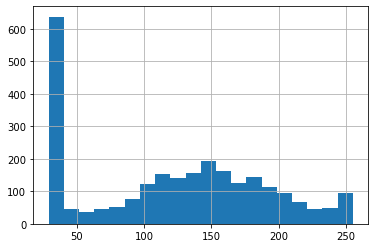

In [ ]:
recap_res_r2['sharp'][recap_res_r2['scratch_flag'] == 1].hist(bins=20)

In [ ]:
recap_res_r2['sharp'][recap_res_r2['scratch_flag'] == 1].describe()

count    2559.000000
mean      122.136772
std        66.831127
min        29.000000
25%        41.000000
50%       128.000000
75%       173.000000
max       255.000000
Name: sharp, dtype: float64

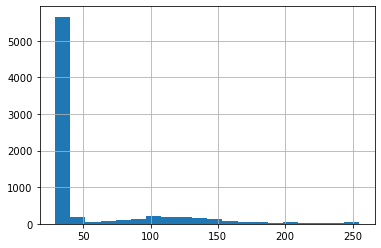

In [ ]:
recap_res_r2['sharp'][recap_res_r2['scratch_flag'] == 0].hist(bins=20)

In [ ]:
recap_res_r2['sharp'][recap_res_r2['scratch_flag'] == 0].describe()

count    7441.000000
mean       54.664830
std        43.347759
min        29.000000
25%        33.000000
50%        35.000000
75%        40.000000
max       255.000000
Name: sharp, dtype: float64

Wow, look at that! 

Now let's assume that over 100 maximum 'sharp' values means there must be a scratch defect, let's see how many of image got bad label (I know that's too generous, knowing the distribution from round 1)

In [ ]:
bad_label = recap_res_r2['sharp'][recap_res_r2['scratch_flag'] == 0] > 100

In [ ]:
recap1_falneg = recap_res_r2[(recap_res_r2['scratch_flag'] == 0) & (recap_res_r2['sharp']>100)]
recap1_falneg

filename  scratch_small  scratch_large  dent_small  dent_large  \
12    JmGDWGBWY8.png              0              0           1           0   
27    MiU3mPyHq5.png              0              0           0           0   
30    AUQYeyEEnp.png              0              0           0           0   
42    q3YgefTyOq.png              0              0           0           0   
54    c3qDX8KcFd.png              0              0           0           0   
...              ...            ...            ...         ...         ...   
9979  BXyL57EhSG.png              0              0           0           0   
9981  DofmSnpIPp.png              0              0           0           0   
9989  KfJC6lktgz.png              0              0           0           0   
9992  EqmgjbWe2r.png              0              0           0           0   
9997  jFNmZC4LF4.png              0              0           0           0   

      stray_particle  discoloration  scratch_flag  sharp  min_size  ...  c30  \
12                 0              0             0  122.0       7.0  ...  0.0   
27                 0              0             0  145.0       7.0  ...  2.0   
30                 0              0             0  195.0       7.0  ...  1.0   
42                 0              0             0  188.0       7.0  ...  5.0   
54                 0              0             0  145.0       7.0  ...  1.0   
...              ...            ...           ...    ...       ...  ...  ...   
9979               1              0             0  133.0       7.0  ...  2.0   
9981               1              0             0  108.0       7.0  ...  0.0   
9989               1              0             0  125.0       7.0  ...  1.0   
9992               1              0             0  136.0       7.0  ...  0.0   
9997               1              0             0  116.0       7.0  ...  0.0   

      c40  c50  c80  c100  c150  c200  c300  c400  c500  
12    0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
27    0.0  2.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
30    1.0  0.0  2.0   1.0   0.0   1.0   0.0   0.0   0.0  
42    1.0  3.0  0.0   0.0   0.0   0.0   0.0   1.0   0.0  
54    0.0  0.0  0.0   0.0   0.0   0.0   1.0   0.0   0.0  
...   ...  ...  ...   ...   ...   ...   ...   ...   ...  
9979  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9981  1.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9989  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9992  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9997  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[1176 rows x 26 columns]

THERE ARE over 10% of theeeeeem?? 

it's still only the false negative. you don't believe me? 

let's plot some of the images!

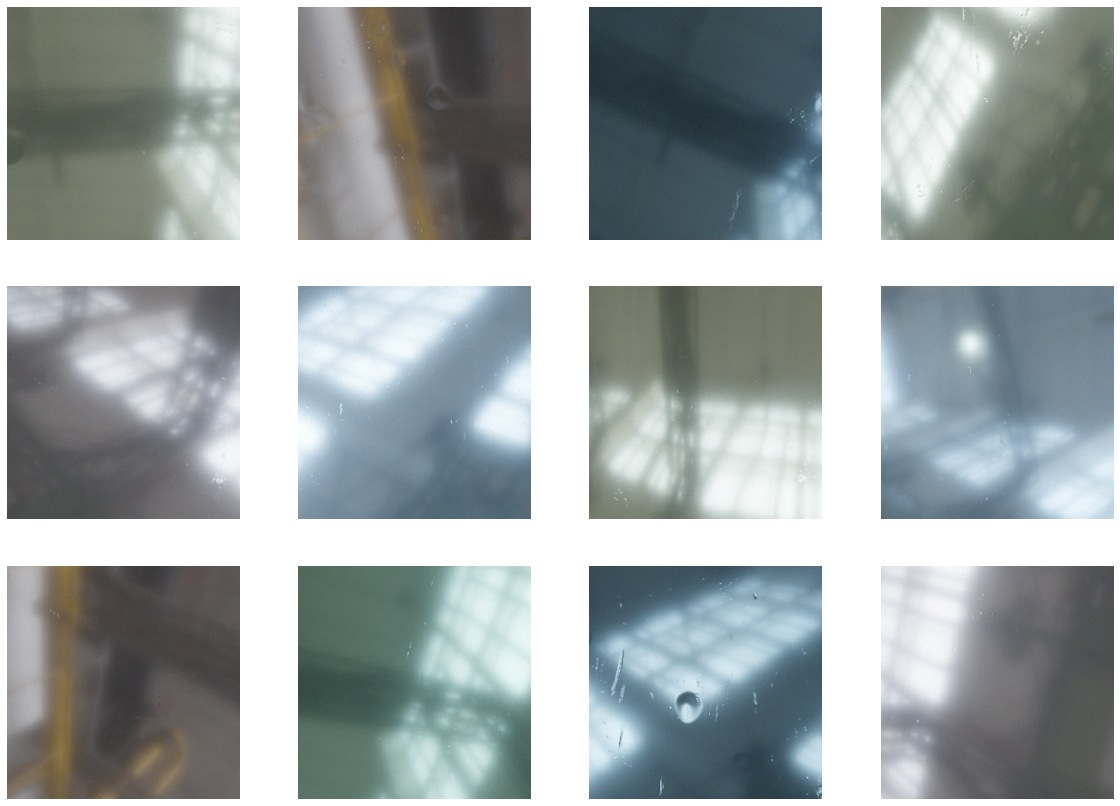

In [ ]:
plt.figure(figsize=(20, 30))
for i in range(12):
    ax = plt.subplot(6, 4, 1*i + 1)
    fname = r'./data_round2/unlabelled/images/' + recap1_falneg.iloc[i,0]
    im = Image.open(fname)
    plt.imshow(im)
    plt.axis("off")

wow that's a lot of scratches! so more than ~15% wrongly labelled scratch?? I guess it's time to change the oracle haha. 

let's see the false positive one. Again, this parameter is still to generous.

In [ ]:
recap1_falpos = recap_res_r2[(recap_res_r2['scratch_flag'] == 1) & (recap_res_r2['sharp']<40)]
recap1_falpos

filename  scratch_small  scratch_large  dent_small  dent_large  \
18    NvWJHmhA3k.png              1              0           0           0   
26    ayzAXNfGTA.png              1              0           1           0   
44    KdphL7Ovnl.png              1              0           0           0   
58    krNn3cMauC.png              1              1           1           0   
68    xRm9rCBAZj.png              1              0           0           0   
...              ...            ...            ...         ...         ...   
9745  ZsZM5C74uH.png              1              1           0           0   
9926  PAGpWtPtfl.png              1              0           0           0   
9954  pJSlA2KY2d.png              1              0           1           0   
9966  eU7XY7TIL6.png              1              0           1           0   
9984  UpOyGdUn4o.png              1              1           0           1   

      stray_particle  discoloration  scratch_flag  sharp  min_size  ...  c30  \
18                 0              0             1   34.0       7.0  ...  0.0   
26                 1              0             1   34.0       7.0  ...  0.0   
44                 0              0             1   33.0       7.0  ...  0.0   
58                 0              0             1   33.0       7.0  ...  0.0   
68                 0              0             1   34.0       7.0  ...  0.0   
...              ...            ...           ...    ...       ...  ...  ...   
9745               0              0             1   38.0       7.0  ...  0.0   
9926               0              0             1   35.0       7.0  ...  0.0   
9954               0              0             1   36.0       7.0  ...  0.0   
9966               0              0             1   35.0       7.0  ...  0.0   
9984               0              1             1   32.0       7.0  ...  0.0   

      c40  c50  c80  c100  c150  c200  c300  c400  c500  
18    0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
26    0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
44    0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
58    0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
68    0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...   ...  ...  ...   ...   ...   ...   ...   ...   ...  
9745  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9926  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9954  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9966  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9984  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[632 rows x 26 columns]

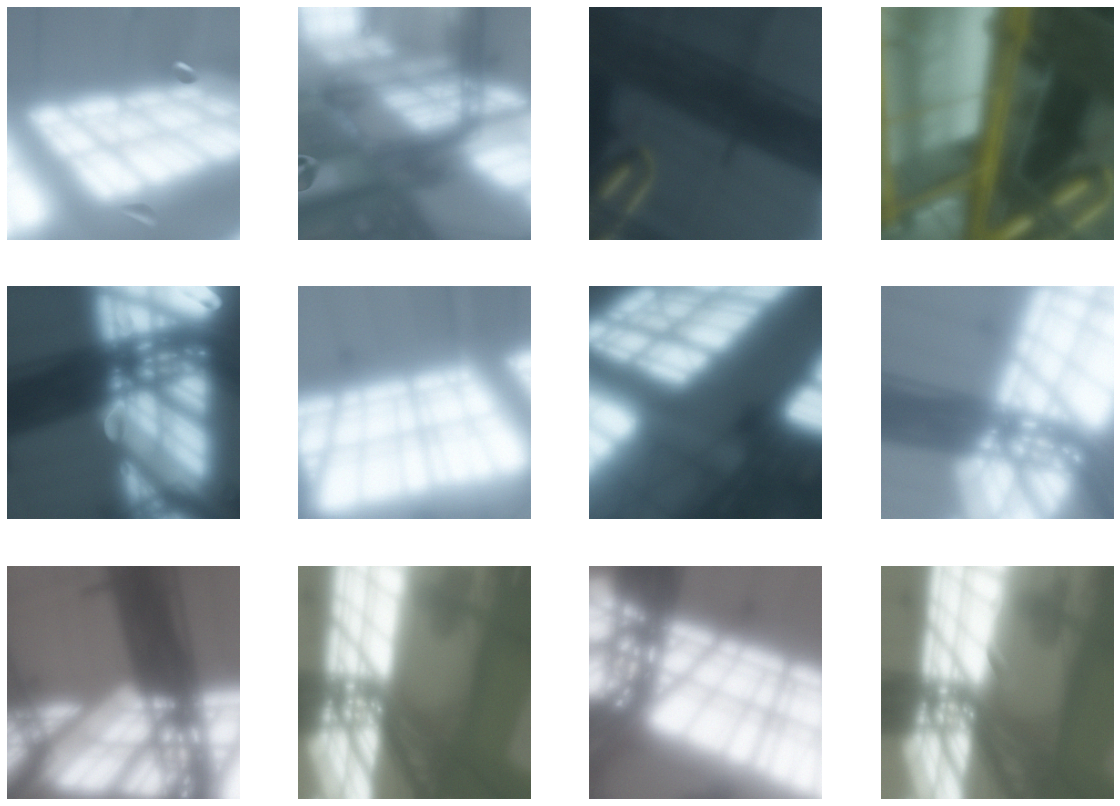

In [ ]:
plt.figure(figsize=(20, 30))
for i in range(12):
    ax = plt.subplot(6, 4, 1*i + 1)
    fname = r'./data_round2/unlabelled/images/' + recap1_falpos.iloc[i,0]
    im = Image.open(fname)
    plt.imshow(im)
    plt.axis("off")

no scratch~

And that's it! you can fiddle around the other features from the cv to differentiate other labels specifically.

hope this will inspire or help you guys. don't forget to leave a likes   ❤️  !